# 🎡 08-03-2024

In [1]:
from __future__ import print_function

import sys
import yaml
from tqdm import tqdm
import os

from msmd.data_model.piece import Piece
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Enable autoreload
%load_ext autoreload

# Set autoreload mode to reload all modules every time before executing code
%autoreload 2

In [2]:
# To change to the path in the server

split_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd/msmd/splits/all_split.yaml'
config_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/audio_sheet_retrieval/exp_configs/mutopia_no_aug.yaml'
DATA_ROOT_MSMD = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd_aug_v1-1_no-audio'
snippets_dir = "/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3"


with open(config_file, 'rb') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
def load_split(split_file):
    with open(split_file, 'rb') as f:
        split = yaml.load(f, Loader=yaml.FullLoader)
    return split

In [3]:
files = load_split(split_file)

In [4]:
files.keys()

dict_keys(['test', 'train', 'valid'])

In [5]:
len(files['test'])

94

In [6]:
SHEET_CONTEXT = 200
SYSTEM_HEIGHT = 160
SPEC_CONTEXT = 42
SPEC_BINS = 92


NO_AUGMENT = dict()
NO_AUGMENT['system_translation'] = 0
NO_AUGMENT['sheet_scaling'] = [1.00, 1.00]
NO_AUGMENT['onset_translation'] = 0
NO_AUGMENT['spec_padding'] = 0
NO_AUGMENT['interpolate'] = -1
NO_AUGMENT['synths'] = ['ElectricPiano']
NO_AUGMENT['tempo_range'] = [1.00, 1.00]

# this will be overwritten with a config file
# (see audio_sheet_retrieval/exp_configs)
AUGMENT = dict()
for key in NO_AUGMENT.keys():
    AUGMENT[key] = NO_AUGMENT[key]
    
if not config_file:
    spec_context = SPEC_CONTEXT
    sheet_context = SHEET_CONTEXT
    staff_height = SYSTEM_HEIGHT
    augment = AUGMENT
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
else:
    with open(config_file, 'rb') as hdl:
        config = yaml.load(hdl, Loader=yaml.FullLoader)
    spec_context = config["SPEC_CONTEXT"]
    sheet_context = config["SHEET_CONTEXT"]
    staff_height = config["SYSTEM_HEIGHT"]
    augment = config["AUGMENT"]
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
    test_augment['synths'] = [config["TEST_SYNTH"]]
    test_augment['tempo_range'] = [config["TEST_TEMPO"], config["TEST_TEMPO"]]



In [7]:
# Get piece names present in the directory
# Skip that for now

In [8]:

piece_names = ['SatieE__gymnopedie_1__gymnopedie_1', 'Yaniewicz__leslanciers__leslanciers', 'WanhalJ__O42__wanhal-rondo']#, 'BachJS__BWV952__fugue-c-major', 'Mendelssohn-BartholdyF__O19__5.Inquietude', 'SchumannR__O124__16-berceuse', 'PachelbelJ__fugue-3-7__fugue-3-7']
# all_images = []
# all_specs = []
# all_o2c_maps = []
# piece_pools = []
for i in tqdm(range(len(piece_names))):#, ncols=70, total=len(piece_names)):
    piece_name = piece_names[i]
    print(piece_name)

100%|██████████| 3/3 [00:00<00:00, 40590.04it/s]

SatieE__gymnopedie_1__gymnopedie_1
Yaniewicz__leslanciers__leslanciers
WanhalJ__O42__wanhal-rondo


In [9]:
# To change to get all files present in the directory
from audio_sheet_retrieval.utils.data_pools import prepare_piece_data, AudioScoreRetrievalPool

piece_names = ['SatieE__gymnopedie_1__gymnopedie_1', 'Yaniewicz__leslanciers__leslanciers', 'WanhalJ__O42__wanhal-rondo']#, 'BachJS__BWV952__fugue-c-major', 'Mendelssohn-BartholdyF__O19__5.Inquietude', 'SchumannR__O124__16-berceuse', 'PachelbelJ__fugue-3-7__fugue-3-7']
# all_images = []
# all_specs = []
# all_o2c_maps = []
# piece_pools = []
for i in tqdm(range(len(piece_names)), ncols=100):
    piece_name = piece_names[i]

    try:
        piece_image, piece_specs, piece_o2c_maps = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False)
        piece_pool = AudioScoreRetrievalPool([piece_image], [piece_specs], [piece_o2c_maps], data_augmentation=test_augment, shuffle=False)
        # piece_pools.append(piece_pool)
        # print(len(piece_image), len(piece_specs[0]), len(piece_o2c_maps[0]))

        piece_name = piece_names[i]
        piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
        performances =  piece.available_performances
        snippets_piece_dir = os.path.join(snippets_dir, piece_name)
        sheet_snippets_dir = os.path.join(snippets_piece_dir, 'sheet_snippets')
        exceprt_snippets_dir = os.path.join(snippets_piece_dir, 'performances')

        # Score
        # performances =  piece.available_performances
        # iterate sheets
        for i_sheet, sheet in enumerate(piece_pool.images):

            # iterate spectrograms
            for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
                # print(f' {sheet_snippets_dir}')
                images_dir = os.path.join(sheet_snippets_dir, performances[i_spec])
                performance_dir = os.path.join(exceprt_snippets_dir, performances[i_spec])
                
                # for i_onset in range(5):
                for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_spec])):

                    # print(f'  {i_onset}')

                    snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)

                    if not os.path.exists(images_dir):
                        os.makedirs(images_dir)
                    # print(snippet.shape)
                    plt.imsave(f'{images_dir}/{performances[i_spec]}_{i_onset}.png', snippet)

                    excerpt = piece_pool.prepare_train_audio(i_sheet, i_spec, i_onset)
                    if not os.path.exists(performance_dir):
                        os.makedirs(performance_dir)
                    plt.imsave(f'{performance_dir}/{performances[i_spec]}_{i_onset}.png', excerpt)                
    except:
        print("Problems with loading piece %s" % piece_name)
        print(sys.exc_info()[0])
        continue


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:58<00:00, 19.65s/it]


In [10]:
for piece_pool in piece_pools:
    print(len(piece_pool.images), len(piece_pool.images[0]), piece_pool.images[0].shape)

1 200 (200, 2968)
1 200 (200, 8267)


In [11]:
len(piece_pool.specs), len(piece_pool.specs[0]),len(piece_pool.specs[0][8][0]), len(piece_pool.o2c_maps), len(piece_pool.o2c_maps[0]), len(piece_pool.o2c_maps[0][14][0])

(1, 15, 3221, 1, 15, 2)

In [12]:
# len(piece_pool.specs[0][14][0][])
# spec = piece_pool.specs[0][i_performance][i_sheet][i_spec]
for i_spec, spec in enumerate(piece_pool.specs[0]):
    print(i_spec)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [13]:
piece = Piece(root=DATA_ROOT_MSMD, name=piece_names[1])
for perf in piece.available_performances:
    print(f'perf: {perf} | {perf.split("tempo-")[1]}')

perf: BachJS__BWV790__bwv790_tempo-1000_ElectricPiano | 1000_ElectricPiano
perf: BachJS__BWV790__bwv790_tempo-1000_YamahaGrandPiano | 1000_YamahaGrandPiano
perf: BachJS__BWV790__bwv790_tempo-1000_acoustic_piano_imis_1 | 1000_acoustic_piano_imis_1
perf: BachJS__BWV790__bwv790_tempo-1000_grand-piano-YDP-20160804 | 1000_grand-piano-YDP-20160804
perf: BachJS__BWV790__bwv790_tempo-1050_acoustic_piano_imis_1 | 1050_acoustic_piano_imis_1
perf: BachJS__BWV790__bwv790_tempo-1100_acoustic_piano_imis_1 | 1100_acoustic_piano_imis_1
perf: BachJS__BWV790__bwv790_tempo-1250_grand-piano-YDP-20160804 | 1250_grand-piano-YDP-20160804
perf: BachJS__BWV790__bwv790_tempo-1500_grand-piano-YDP-20160804 | 1500_grand-piano-YDP-20160804
perf: BachJS__BWV790__bwv790_tempo-1750_grand-piano-YDP-20160804 | 1750_grand-piano-YDP-20160804
perf: BachJS__BWV790__bwv790_tempo-2000_grand-piano-YDP-20160804 | 2000_grand-piano-YDP-20160804
perf: BachJS__BWV790__bwv790_tempo-500_grand-piano-YDP-20160804 | 500_grand-piano-YDP-

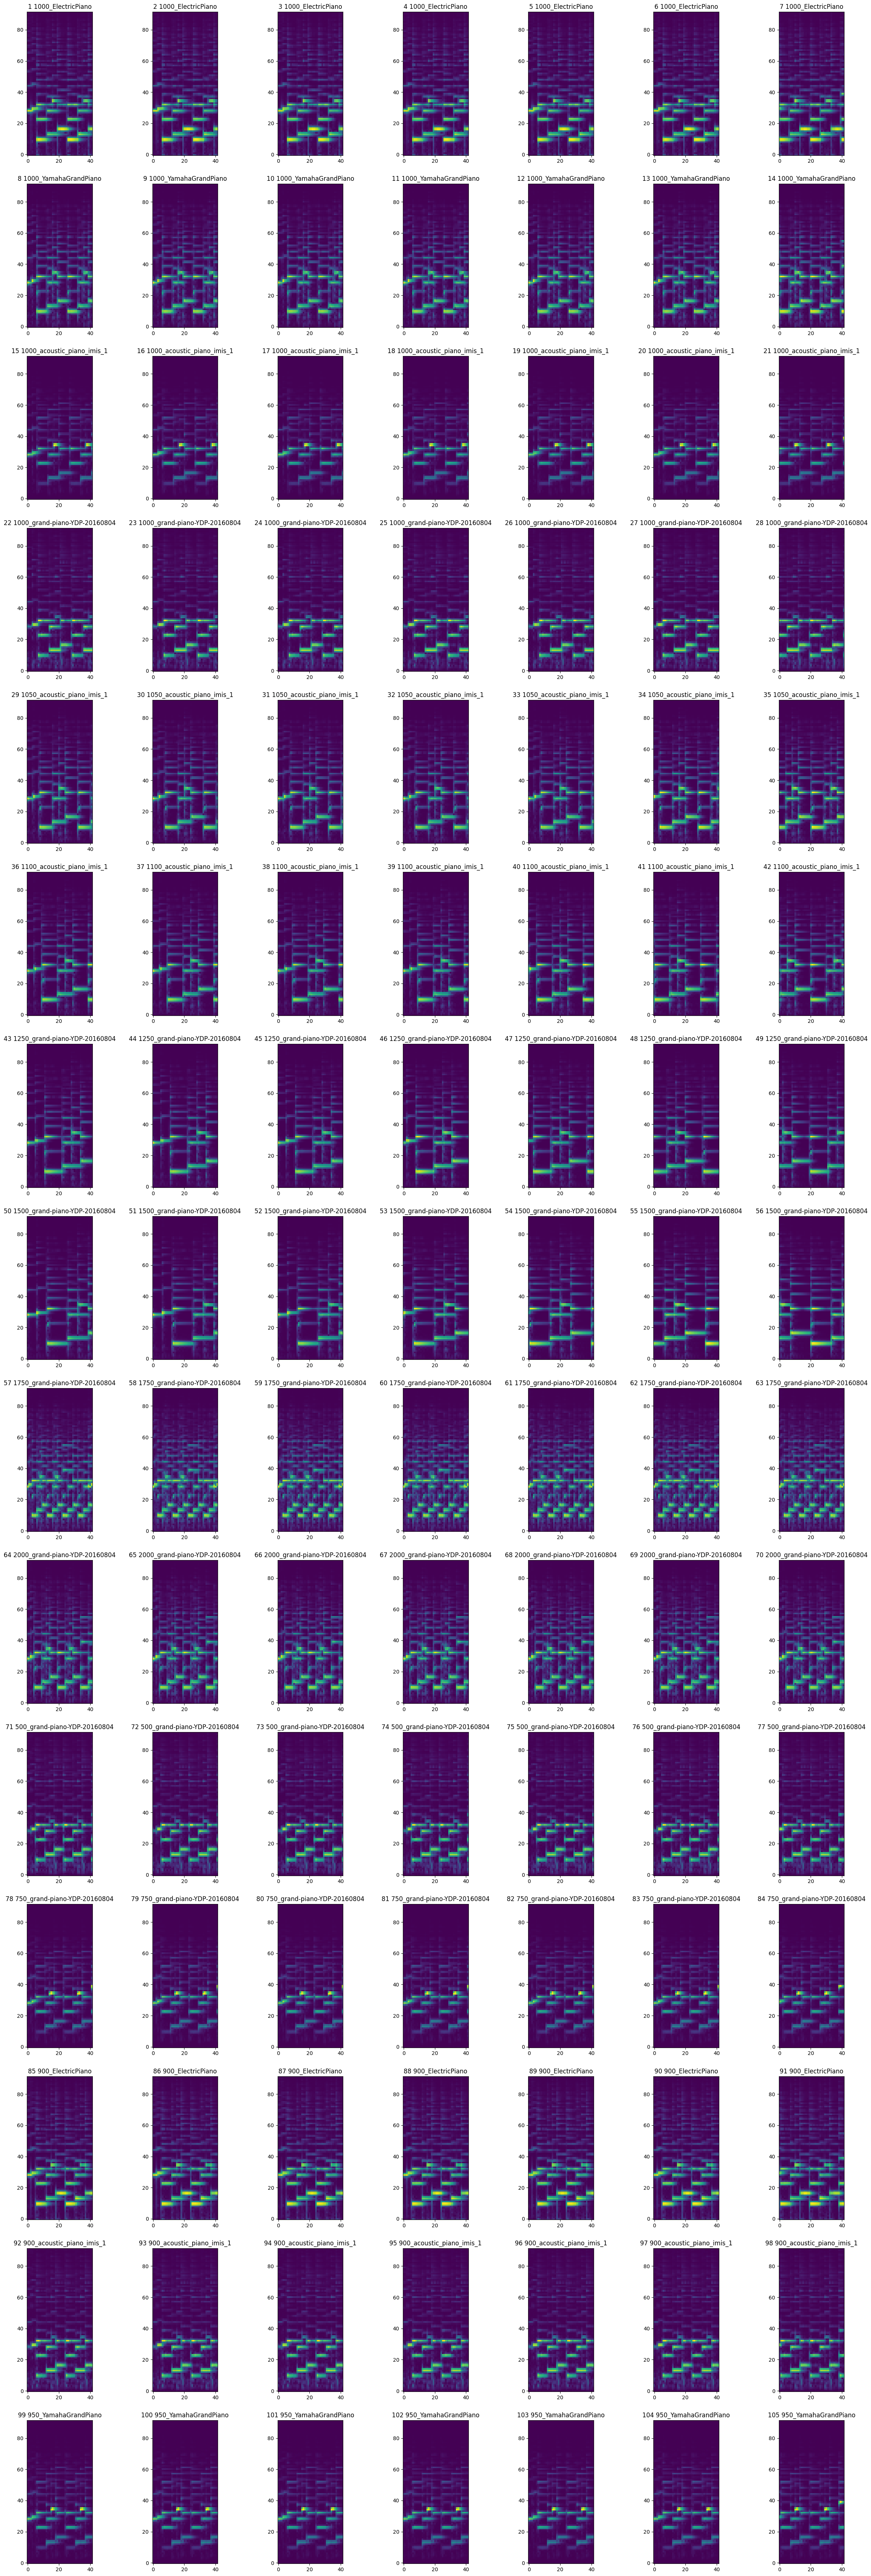

In [14]:
plt.figure('specs', figsize=(30,90))

order = 1
# for piece_name in piece_names:

piece_pool = piece_pools[0]
piece = Piece(root=DATA_ROOT_MSMD, name=piece_names[1])
for i_spec, spec in enumerate(piece_pool.specs[0]):
    for i_onset in range(7):
    # for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_sheet])):


        excerpt = piece_pool.prepare_train_audio(0, i_spec, i_onset)
        plt.subplot(15, 7, order)

        plt.imshow(excerpt, cmap='viridis', origin='lower')
        plt.title(f'{order} {piece.available_performances[i_spec].split("tempo-")[1]}')
        order+=1
    


# 🛼 **12-03-2024** Getting ready to save

In [15]:
# Store the files in the directories
snippets_dir = "/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_2"


In [16]:
os.listdir(snippets_dir)

['BachJS__BWV952__fugue-c-major',
 '.DS_Store',
 'SchumannR__O124__16-berceuse',
 'BachJS__BWV790__bwv790',
 'Anonymous__lanative__lanative',
 'Mendelssohn-BartholdyF__O19__5.Inquietude',
 'PachelbelJ__fugue-3-7__fugue-3-7']

## 🃏 Snippets

In [17]:
for i_piece_pool, piece_pool in tqdm(enumerate(piece_pools)):
    # print(i_piece_pool)
    piece_name = piece_names[i_piece_pool]
    piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
    snippets_piece_dir = os.path.join(snippets_dir, piece_name)

    sheet_snippets_dir = os.path.join(snippets_piece_dir, 'sheet_snippets')
    # performances =  piece.available_performances
     # iterate sheets
    for i_sheet, sheet in enumerate(piece_pool.images):

        # iterate spectrograms
        for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
            # print(f' {sheet_snippets_dir}')
            
            for i_onset in range(5):
                # print(f'  {i_onset}')

                snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)
                

                if not os.path.exists(sheet_snippets_dir):
                    os.makedirs(sheet_snippets_dir)
                # print(snippet.shape)
                # plt.imsave(f'{sheet_snippets_dir}/{piece_name}_{i_onset}.png', snippet)





2it [00:00, 170.08it/s]


## 🧫 Excerpts

In [18]:
piece.available_performances

['BachJS__BWV790__bwv790_tempo-1000_ElectricPiano',
 'BachJS__BWV790__bwv790_tempo-1000_YamahaGrandPiano',
 'BachJS__BWV790__bwv790_tempo-1000_acoustic_piano_imis_1',
 'BachJS__BWV790__bwv790_tempo-1000_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-1050_acoustic_piano_imis_1',
 'BachJS__BWV790__bwv790_tempo-1100_acoustic_piano_imis_1',
 'BachJS__BWV790__bwv790_tempo-1250_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-1500_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-1750_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-2000_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-500_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-750_grand-piano-YDP-20160804',
 'BachJS__BWV790__bwv790_tempo-900_ElectricPiano',
 'BachJS__BWV790__bwv790_tempo-900_acoustic_piano_imis_1',
 'BachJS__BWV790__bwv790_tempo-950_YamahaGrandPiano']

In [19]:
for i_piece_pool, piece_pool in tqdm(enumerate(piece_pools), total=len(piece_pools)):
    # print(i_piece_pool)
    piece_name = piece_names[i_piece_pool]
    piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
    snippets_piece_dir = os.path.join(snippets_dir, piece_name)

    exceprt_snippets_dir = os.path.join(snippets_piece_dir, 'performances')
    performances =  piece.available_performances
     # iterate sheets
    for i_sheet, sheet in enumerate(piece_pool.images):

        # iterate spectrograms
        for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
            performance_dir = os.path.join(exceprt_snippets_dir, performances[i_spec])
            # print(f' {performances[i_spec]}')
            # iterate onsets in sheet
            # for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_spec])):
            for i_onset in range(5):
                # print(f'  {i_onset}')

                excerpt = piece_pool.prepare_train_audio(i_sheet, i_spec, i_onset)
                # plt.subplot(15, 7, order)

                # plt.imshow(excerpt, cmap='viridis', origin='lower')
                # plt.title(f'{order} {piece.available_performances[i_spec].split("tempo-")[1]}')
                # order+=1

                if not os.path.exists(performance_dir):
                    os.makedirs(performance_dir)
                # plt.imsave(f'{performance_dir}/{performances[i_spec]}_{i_onset}.png', excerpt)





100%|██████████| 2/2 [00:00<00:00, 172.55it/s]


In [47]:
# for e in (piece_pool.train_entities):
    # print(e)

# 🎍 Failed attempts i think

In [ ]:
plt.figure('o2c_maps', figsize=(10, 60))
plotting = 1

for i_sheet, sheet in enumerate(piece_pool.images):
    print('Sheet: ', i_sheet)
    for i_spec, spec in enumerate(piece_pool.specs[i_sheet][:1]):
        # for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_sheet])):
        order = 0
        print('Spec: ', i_spec)
        for i_onset in range(22):
            print(f'WHat: {i_onset}')

            snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)
            excerpt = piece_pool.prepare_train_audio(i_sheet, i_spec, i_onset)
            # coord = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 1]
            # c_start = coord - piece_pool.sheet_context//2
            # c_stop = c_start + piece_pool.sheet_context

            # onset = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 0]
            # o_start = onset - piece_pool.spec_context//2
            # o_stop = o_start + piece_pool.spec_context

            # if o_start>=0 and o_stop<spec.shape[1] and c_start>=0 and c_stop<sheet.shape[1]
            # print(plotting)
            plt.subplot(23, 2, plotting)
            plotting+=1

            plt.imshow(snippet, cmap='gray')
            plt.plot([snippet.shape[1]//2, snippet.shape[1]//2], [0, snippet.shape[0]], 'g-', alpha=.8, linewidth=2)
            plt.title(order)

            plt.subplot(23, 2, plotting)
            plotting+=1

            plt.imshow(excerpt, cmap='magma', origin='lower')
            plt.plot([excerpt.shape[1]//2, excerpt.shape[1]//2], [0, excerpt.shape[0]], 'w-', alpha=.8, linewidth=2)
            plt.title(order)
            
plt.show() 
            

In [8]:
for pool in piece_pools:
    for s in pool.specs:

        print(len(pool.specs), len(s))
        for m in s:
            print("     ", len(m))
        

1 15
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
1 15
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
1 15
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
1 15
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
1 15
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1
      1


In [9]:
# Store the files in the directories
snippets_dir = "/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_2"


In [10]:
snippets = []
for piece_pool, piece_name in zip(piece_pools[:1], piece_names[:1]):
    snippets_piece_dir = os.path.join(snippets_dir, piece_name)
    
    for i in range(len(piece_pool.performance_names)):
        print(f'{i} | {piece_pool.performance_names[i][i]}, {len(piece_pool.images[i][i])}')
    # Save score snippets
    # score_snippets_dir = os.path.join(snippets_piece_dir, 'snippets')
    # for i in range(len(piece_pool.train_entities)):
    #     # get batch
        if i.__class__ == int:
            key = slice(i, i + 1)
        batch_entities = piece_pool.train_entities[key]

        for i_entity, (i_sheet, i_spec, i_onset) in enumerate(batch_entities):
            snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)
            plt.subplot(23, 2, plotting)

            print(len(snippets))
    #         snippets.append(snippet)
    #         # if not os.path.exists(score_snippets_dir):
    #         #     os.makedirs(score_snippets_dir)
    #         # plt.imsave(f'{score_snippets_dir}/{piece_name}_{i}.png', snippet)

    # print(f'Piece Name: {piece_name}')
    # # Save performance snippets
    # for performance in piece_pool.performance_names[0]:
    #     print(f'    {performance}')
    

0 | BachJS__BWV790__bwv790_tempo-1000_ElectricPiano, 8267


Sheet:  0
Spec:  0
WHat: 0
WHat: 1
WHat: 2
WHat: 3
WHat: 4
WHat: 5
WHat: 6
WHat: 7
WHat: 8
WHat: 9
WHat: 10
WHat: 11
WHat: 12
WHat: 13
WHat: 14
WHat: 15
WHat: 16
WHat: 17
WHat: 18
WHat: 19
WHat: 20
WHat: 21


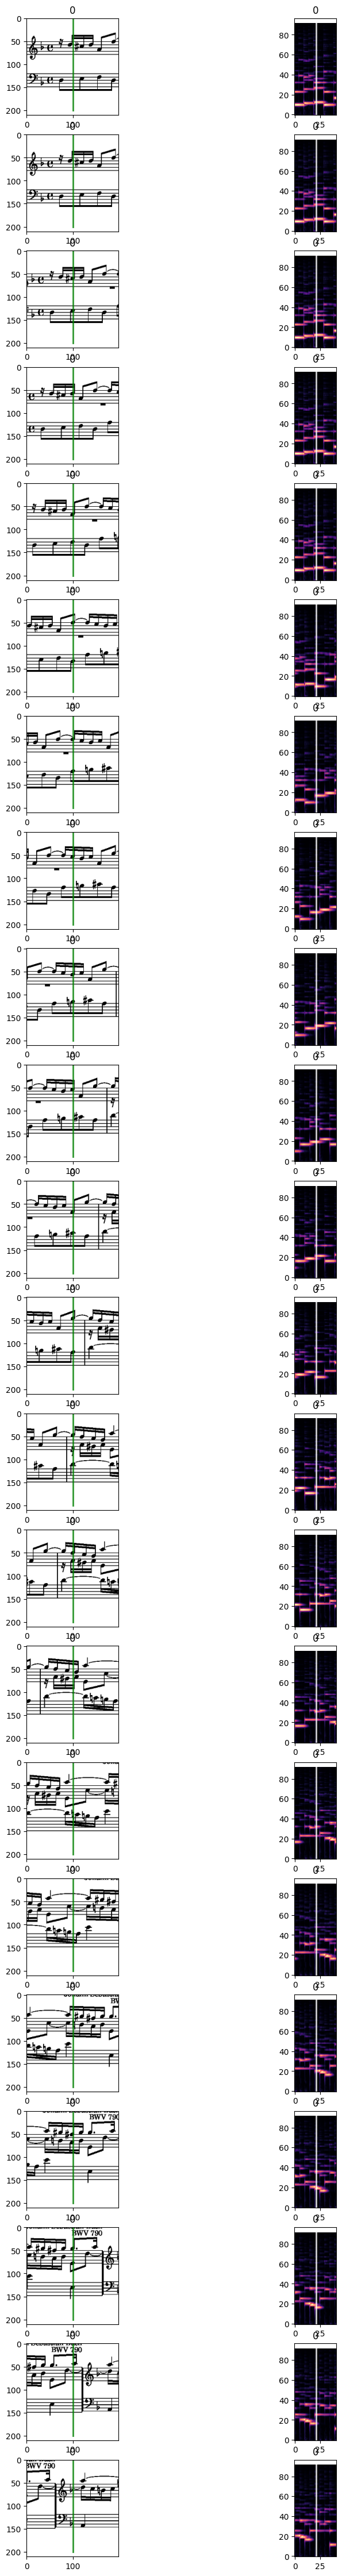

In [33]:
plt.figure('o2c_maps', figsize=(10, 60))
plotting = 1

for i_sheet, sheet in enumerate(piece_pool.images):
    print('Sheet: ', i_sheet)
    for i_spec, spec in enumerate(piece_pool.specs[i_sheet][:1]):
        # for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_sheet])):
        order = 0
        print('Spec: ', i_spec)
        for i_onset in range(22):
            print(f'WHat: {i_onset}')

            snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)
            excerpt = piece_pool.prepare_train_audio(i_sheet, i_spec, i_onset)
            # coord = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 1]
            # c_start = coord - piece_pool.sheet_context//2
            # c_stop = c_start + piece_pool.sheet_context

            # onset = piece_pool.o2c_maps[i_sheet][i_spec][i_onset, 0]
            # o_start = onset - piece_pool.spec_context//2
            # o_stop = o_start + piece_pool.spec_context

            # if o_start>=0 and o_stop<spec.shape[1] and c_start>=0 and c_stop<sheet.shape[1]
            # print(plotting)
            plt.subplot(23, 2, plotting)
            plotting+=1

            plt.imshow(snippet, cmap='gray')
            plt.plot([snippet.shape[1]//2, snippet.shape[1]//2], [0, snippet.shape[0]], 'g-', alpha=.8, linewidth=2)
            plt.title(order)

            plt.subplot(23, 2, plotting)
            plotting+=1

            plt.imshow(excerpt, cmap='magma', origin='lower')
            plt.plot([excerpt.shape[1]//2, excerpt.shape[1]//2], [0, excerpt.shape[0]], 'w-', alpha=.8, linewidth=2)
            plt.title(order)
            
plt.show() 
            